In [13]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple, Dict, Any, Optional
from tqdm import tqdm

from oceanrl import query  # query(salmon, shark, effort, month) -> (caught, salmon_tp1, shark_tp1)

# Reproducibility
np.random.seed(690)


In [42]:
class SARSAgent:
    def __init__(
        self,
        *,
        salmon_t0: float,
        shark_t0: float,
        env_step: Callable[[float, float, float, int], Tuple[float, float, float]],
        max_month: int = 900,
        salmon_bins: int = 20,
        shark_bins: int = 20,
        action_bins: int = 41,
        effort_cap: float = 36.0,
        gamma: float = 0.995,
        alpha: float = 0.2,
        epsilon: float = 0.1,
        K1: float = 1e-3,
        K2: float = 1e-2,
        K3: float = 100.0,
        K4: float = 100.0,
        q_init: float = 2000.0,
    ):
        self.salmon0 = float(salmon_t0)
        self.shark0  = float(shark_t0)
        self.max_month = int(max_month)
        self.env_step = env_step

        self.salmon_bins = int(salmon_bins)
        self.shark_bins  = int(shark_bins)
        self.action_bins = int(action_bins)
        self.effort_cap  = float(effort_cap)

        self.gamma = float(gamma)
        self.alpha = float(alpha)
        self.epsilon = float(epsilon)

        self.K1, self.K2, self.K3, self.K4 = float(K1), float(K2), float(K3), float(K4)

        # Q-table: [S, K, M, A]
        self.q = np.full((self.salmon_bins, self.shark_bins, self.max_month, self.action_bins),
                         float(q_init), dtype=np.float64)

        # running state during interaction
        self._reset_state()

    # ---------- Public API ----------
    def _reset_state(self):
        self.s = self.salmon0
        self.k = self.shark0
        self.m = 1

    def reset(self):
        self._reset_state()
        s_idx = self._discretize((self.s, self.k, self.m))
        a_idx = self._epsilon_greedy(s_idx)
        return s_idx, a_idx

    def step(self, a_idx: int):
        effort = self._a_to_effort(a_idx)
        caught, s1, k1 = self.env_step(self.s, self.k, effort, self.m)
        r = self._reward(caught, effort)

        # transition
        self.s, self.k = float(s1), float(k1)
        self.m += 1
        done = self.m > self.max_month
        if done:
            r += self._terminal_bonus(self.s, self.k)

        s1_idx = None
        a1_idx = None
        if not done:
            s1_idx = self._discretize((self.s, self.k, self.m))
            a1_idx = self._epsilon_greedy(s1_idx)
        return r, s1_idx, a1_idx, done

    def update(self, s_idx, a_idx, r, s1_idx, a1_idx, done: bool):
        si, ki, mi = s_idx
        mi -= 1
        if done:
            td_target = r
        else:
            s1i, k1i, m1i = s1_idx
            m1i -= 1
            td_target = r + self.gamma * self.q[s1i, k1i, m1i, a1_idx]
        td_error = td_target - self.q[si, ki, mi, a_idx]
        self.q[si, ki, mi, a_idx] += self.alpha * td_error

    # ---------- Policy ----------
    def _epsilon_greedy(self, s_idx):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_bins)
        si, ki, mi = s_idx
        mi -= 1
        row = self.q[si, ki, mi, :]
        best = np.max(row)
        best_actions = np.flatnonzero(row == best)
        return int(np.random.choice(best_actions))

    def act(self, state: Tuple[float, float, int]):
        s_idx = self._discretize(state)
        a_idx = self._epsilon_greedy(s_idx)
        return self._a_to_effort(a_idx)

    # ---------- Helpers ----------
    def _reward(self, caught: float, effort: float) -> float:
        return self.K1 * float(caught) - self.K2 * float(effort)

    def _terminal_bonus(self, s: float, k: float) -> float:
        eps = 1e-10
        return self.K3 * np.log(max(s, eps)) + self.K4 * np.log(max(k, eps))

    def _discretize(self, state: Tuple[float, float, int]):
        s, k, m = state
        # heuristic caps for binning stability
        S_MAX = max(self.salmon0 * 5.0, 1e-9)
        K_MAX = max(self.shark0  * 2.0, 1e-9)
        s_ratio = np.clip(float(s) / S_MAX, 0.0, 0.999999)
        k_ratio = np.clip(float(k) / K_MAX, 0.0, 0.999999)
        si = int(np.floor(self.salmon_bins * s_ratio))
        ki = int(np.floor(self.shark_bins  * k_ratio))
        mi = int(np.clip(int(m), 1, self.max_month))  # keep month 1-based
        return (si, ki, mi)

    def _a_to_effort(self, a_idx: int) -> float:
        # midpoint mapping in [0, effort_cap]
        width = self.effort_cap / self.action_bins
        return (int(a_idx) + 0.5) * width



In [43]:
def train_sarsa(
    episodes: int = 2000,
    *,
    salmon_t0: float = 20000.0,
    shark_t0: float = 500.0,
    gamma: float = 0.995,
    alpha: float = 0.2,
    epsilon: float = 0.1,
    salmon_bins: int = 20,
    shark_bins: int = 20,
    action_bins: int = 41,
    effort_cap: float = 36.0,
    q_init: float = 2000.0,
    eps_start: float = 0.2,
    eps_end: float = 0.02,
    eps_decay_steps: int = 4000,
) -> Tuple[SARSAgent, Dict[str, Any]]:
    agent = SARSAgent(
        salmon_t0=salmon_t0,
        shark_t0=shark_t0,
        env_step=query,
        max_month=900,
        salmon_bins=salmon_bins,
        shark_bins=shark_bins,
        action_bins=action_bins,
        effort_cap=effort_cap,
        gamma=gamma,
        alpha=alpha,
        epsilon=eps_start,
        q_init=q_init,
    )

    returns = []
    for ep in tqdm(range(1, episodes + 1), desc="SARSA Episodes"):
        # linear epsilon decay
        frac = min(1.0, (ep - 1) / max(1, eps_decay_steps))
        agent.epsilon = float(eps_start + frac * (eps_end - eps_start))

        G = 0.0
        s_idx, a_idx = agent.reset()
        done = False
        while not done:
            r, s1_idx, a1_idx, done = agent.step(a_idx)
            agent.update(s_idx, a_idx, r, s1_idx, a1_idx, done)
            G += r
            if not done:
                s_idx, a_idx = s1_idx, a1_idx
        returns.append(G)
    logs = {"returns": np.asarray(returns, dtype=np.float64)}
    return agent, logs



In [44]:
class NaiveAgent:
    def act(self, state: Tuple[float, float, int]) -> float:
        return 8.0


def evaluation(agent_like, episodes: int = 1000,
               salmon_t0: float = 20000.0, shark_t0: float = 500.0) -> Dict[str, float]:
    K1, K2, K3, K4 = 1e-3, 1e-2, 100.0, 100.0
    rets = []
    for _ in tqdm(range(episodes), desc="Eval"):
        s, k = salmon_t0, shark_t0
        G = 0.0
        for m in range(1, 901):
            effort = float(agent_like.act((s, k, m)))
            caught, s1, k1 = query(s, k, effort, m)
            G += K1 * float(caught) - K2 * effort
            s, k = float(s1), float(k1)
        G += K3 * np.log(max(s, 1e-10)) + K4 * np.log(max(k, 1e-10))
        rets.append(G)
    arr = np.asarray(rets, dtype=np.float64)
    return {
        "episodes": int(episodes),
        "mean": float(arr.mean()),
        "median": float(np.median(arr)),
        "std": float(arr.std(ddof=1)) if episodes > 1 else 0.0,
        "min": float(arr.min()),
        "max": float(arr.max()),
    }


class SARSAActWrapper:
    """Wraps SARSAgent to expose act(state)->effort for eval()"""
    def __init__(self, agent: SARSAgent):
        self.agent = agent
    def act(self, state: Tuple[float, float, int]) -> float:
        return self.agent.act(state)



In [45]:
def plot_learning_curve(returns: np.ndarray, window: int = 50):
    r = np.asarray(returns, dtype=np.float64)
    x = np.arange(1, r.size + 1)
    plt.figure(figsize=(8,4))
    plt.plot(x, r, alpha=0.3, label="return")
    if r.size >= window:
        c = np.cumsum(np.insert(r, 0, 0.0))
        ma = (c[window:] - c[:-window]) / float(window)
        plt.plot(np.arange(window, r.size + 1), ma, label=f"MA{window}")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("SARSA Training Returns")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_policy_heatmap(agent: SARSAgent, month: int = 1):
    mi = int(np.clip(month, 1, agent.max_month)) - 1
    # greedy action per state grid at month m
    policy = np.argmax(agent.q[:, :, mi, :], axis=2)
    plt.figure(figsize=(6,5))
    im = plt.imshow(policy, origin="lower", aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xlabel("Shark bin")
    plt.ylabel("Salmon bin")
    plt.title(f"Greedy policy (action index) at month {month}")
    plt.tight_layout()
    plt.show()



SARSA Episodes: 100%|██████████| 15000/15000 [03:07<00:00, 80.20it/s]


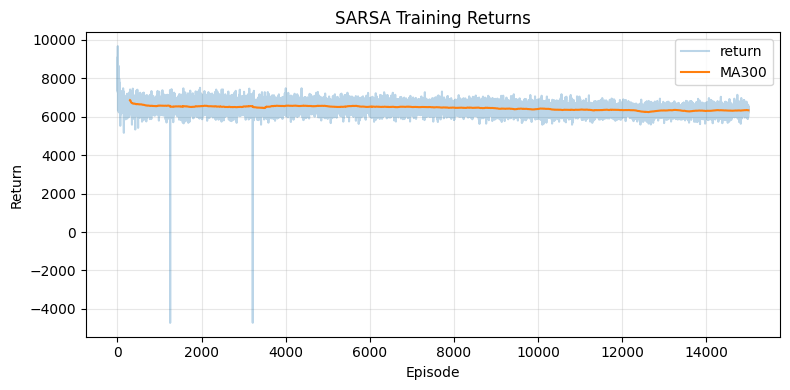

In [48]:
# --- Train SARSA (rollback to stable config) ---
EPISODES = 15000
agent_sarsa, logs_sarsa = train_sarsa(
    episodes=EPISODES,
    salmon_t0=20000.0,
    shark_t0=500.0,
    gamma=1.0,
    alpha=0.10,
    salmon_bins=20,
    shark_bins=20,
    action_bins=41,
    effort_cap=36.0,
    q_init=3000.0,
    eps_start=0.25,
    eps_end=0.02,
    eps_decay_steps=12000,
)

plot_learning_curve(logs_sarsa["returns"], window=300)




In [49]:
# --- One greedy rollout (final totals) ---
K1, K2, K3, K4 = 1e-3, 1e-2, 100.0, 100.0

salmon_t = 20000.0
shark_t  = 500.0

total_salmon_caught = 0.0
total_effort = 0.0

for month_t in range(1, 901):
    eff = float(agent.act((salmon_t, shark_t, month_t)))
    caught, s1, k1 = query(salmon_t, shark_t, eff, month_t)
    total_salmon_caught += float(caught)
    total_effort += eff
    salmon_t, shark_t = float(s1), float(k1)

G = K1*total_salmon_caught - K2*total_effort + K3*np.log(max(salmon_t, 1e-10)) + K4*np.log(max(shark_t, 1e-10))

print(f"Total Expected Return: {G}")
print(f"Total Salmon Caught: {total_salmon_caught}, Total Effort: {total_effort}, "
      f"Salmon at the 75th year: {salmon_t}, Shark at the 75th year: {shark_t}")



Total Expected Return: 7571.584297832658
Total Salmon Caught: 9039827.0, Total Effort: 16475.70731707318, Salmon at the 75th year: 21829.0, Shark at the 75th year: 0.0
